In [21]:
import os
import csv
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import trange
import allan_variance
import pandas as pd
np.random.seed(0)

In [22]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [23]:
def dynamics(dt, state, RW, w_input_noise):
    state_next = np.zeros(9) 
    state_next[0:3] = state[0:3] + state[3:6] * dt + RW[0:3] * np.random.randn(3)    # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                             # omega_dot
    state_next[6:9] = state[6:9] + RW[3:6] * np.random.randn(3)                      # specific force
    return state_next

def dynamics_est(dt, state):
    state_next = np.zeros((len(state), 9))
    for i in range(len(state)):
        state_next[i,0:3] = state[i,0:3] + state[i,3:6] * dt      # omega
        state_next[i,3:6] = np.zeros(3)                           # omega_dot
        state_next[i,6:9] = state[i,6:9]                            # specific force
    return state_next

In [24]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

In [25]:
def measurement(state, pos_r, Rb_si, WN, QN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*num_imus:3+i*num_imus]*np.random.randn(3))
        omega_i = Rb_si_sub @ omega + WN[3+i*num_imus:6+i*num_imus]*np.random.randn(3)
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas


def measurement_est(state_input, pos_r, Rb_si, num_imus):
    meas = np.zeros((6*num_imus, len(state_input)))
    for j in range(len(state_input)):
        state = state_input[j]
        for i in range(num_imus):
            Rb_si_sub = Rb_si[i]
            r_sub = pos_r[i]
            sf = state[6:9]
            omega = state[0:3]
            omega_dot = state[3:6]
            s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub)
            omega_i = Rb_si_sub @ omega
            meas[i*6:6+i*6, j] = np.concatenate((s_i, omega_i))

    return meas

In [26]:
def UKF_disi(state, Cov, R, Q, y_meas, dt, pos_r, Rb_si, num_imus):
	alpha = 1.0
	kappa = 1.0
	beta = 1.0

	# Generate 2n+1 particles for every state
	n = len(state)
	Particles = np.zeros((2*n+1, n))
	Particles[0] = state
	param_lambda = alpha**2*(n+kappa)-n # labmda is a parameter for pertubing the states
	delx = scipy.linalg.sqrtm((n+param_lambda)*Cov)
	for i in range(n):
		Particles[i+1] = state + delx[i]
		Particles[n+i+1] = state - delx[i]

	# Propagate the particles according to discrete time dynamics (2n+1 particles)
	Particles_prior = dynamics_est(dt, Particles)

	# Compute prior state mean and covariance
	w0_m = param_lambda / (n+param_lambda)
	w0_c = param_lambda / (n+param_lambda) + 1.0 - alpha**2 + beta
	wi_mc = 1.0 / (2.0*(n+param_lambda))
	state_prior = w0_m*Particles_prior[0] + np.sum(wi_mc*Particles_prior[1:], axis=0)
	diff = Particles_prior[0] - state_prior
	diff_col = diff[:, np.newaxis]
	diff_row = diff[np.newaxis, :]
	Cov_prior = w0_c * diff_col @ diff_row
	for i in range(1, len(Particles_prior)):
		diff = Particles_prior[i] - state_prior
		diff_col = diff[:, np.newaxis]
		diff_row = diff[np.newaxis, :]
		Cov_prior = Cov_prior + wi_mc * diff_col @ diff_row
	Cov_prior = Cov_prior + R

	# Regenerate particles
	delx = scipy.linalg.sqrtm((n+param_lambda)*Cov)
	Particles_rev = np.zeros((2*n+1, n))
	Particles_rev[0] = state_prior
	for i in range(n):
		Particles_rev[i+1] = state + delx[i]
		Particles_rev[n+i+1] = state - delx[i]

	# Predict measurements for each particle
	Y_part = measurement_est(Particles_rev, pos_r, Rb_si, num_imus)

	# Compute weighted measurement mean and covariance
	y_hat = np.sum(wi_mc*Y_part, axis=1)
	S = np.zeros((len(y_hat), len(y_hat)))
	for i in range(len(Y_part[0])):
		y_diff = Y_part[:,i] - y_hat
		y_diff_col = y_diff[:, np.newaxis]
		y_diff_row = y_diff[np.newaxis, :]
		S = S + wi_mc * y_diff_col @ y_diff_row
		# S = S + wi_mc*(Y_part[i] - y_hat)*(Y_part[i] - y_hat).T
	S = S + Q

	# Determine the cross-covariance between the state and observation
	Sig_xz = np.zeros((len(state_prior),len(y_hat)))
	for i in range(len(Y_part[0])):
		Particles_diff = Particles_rev[i] - state_prior
		Y_part_diff = Y_part[:,i] - y_hat
		Particles_col = Particles_diff[:, np.newaxis] 
		Y_part_row = Y_part_diff[np.newaxis, :]

		Sig_xz = Sig_xz + wi_mc * (Particles_col * Y_part_row)
	
	# Compute the Kalman Gain
	K = Sig_xz @ np.linalg.inv(S)

	# Compute the predicted mean and covariance
	state_est = state_prior + K @ (y_meas - y_hat)
	Cov_est = Cov_prior - K @ S @ K.T

	return state_est, Cov_est

Simulated measurements

In [27]:
# measurements
measurements = np.array(read_txt("../data/imu1.txt"))

'Real' measurements

In [28]:
# imu_paths = [f'../data/Flight_hardware/stochastic_cal_DB{i}.csv' for i in range(1, 7)]

# dfs = [pd.read_csv(path) for path in imu_paths]

# dt = 0.002
# len_time = 360
# time = np.arange(0, len_time, dt)
# num_data = int(len_time / dt)

# df_data = []
# for df in dfs:
#     gx = np.array(df['gx'][1000:num_data+1000])
#     gy = np.array(df['gy'][1000:num_data+1000])
#     gz = np.array(df['gz'][1000:num_data+1000])
#     ax = np.array(df['ax'][1000:num_data+1000])
#     ay = np.array(df['ay'][1000:num_data+1000])
#     az = np.array(df['az'][1000:num_data+1000])
#     df_data.append(np.array([ax, ay, az, gx, gy, gz]))

# df = df_data

The parameters of individiual sensors that are estimated from Allan variance curve

In [29]:
# # accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z

# df1_WN = np.array([4.704, 4.516, 5.270, 5.725, 5.497, 5.598]) * 1e-3
# df2_WN = np.array([4.826, 4.529, 5.156, 5.765, 5.687, 5.525]) * 1e-3
# df3_WN = np.array([4.772, 4.531, 5.379, 5.131, 5.188, 5.407]) * 1e-3
# df4_WN = np.array([4.813, 4.589, 5.246, 5.378, 5.427, 5.023]) * 1e-3
# df5_WN = np.array([4.820, 4.654, 5.366, 5.460, 5.529, 5.263]) * 1e-3
# df6_WN = np.array([4.729, 4.563, 5.394, 5.181, 5.327, 5.419]) * 1e-3
# df_WN  = np.array([df1_WN, df2_WN, df3_WN, df4_WN, df5_WN, df5_WN]).flatten()

# df1_RW = np.array([    0,    0, 4.33,    0, 6.99, 0]) * 1e-4
# df2_RW = np.array([    0, 4.55,    0,    0, 1.18, 0]) * 1e-4
# df3_RW = np.array([    0, 1.72,    0, 4.19, 7.32, 0]) * 1e-4
# df4_RW = np.array([    0, 6.46, 2.46, 8.32,    0, 0]) * 1e-4
# df5_RW = np.array([ 1.43, 3.47, 6.82,    0,    0, 0]) * 1e-4
# df6_RW = np.array([ 4.19, 1.41, 5.60, 5.12,    0, 0]) * 1e-4
# df_RW = np.stack([df1_RW, df2_RW, df3_RW, df4_RW, df5_RW, df6_RW])

In [30]:
num_imus = 3
filename = "../data/UKF.txt"

# Rb  = []
# pos = []
# WN  = []
# measurements = []
# for j in range(num_imus):
#     # pos.append(np.random.rand(3)) # position of jth imu in DISIMU
#     Rb.append(np.eye(3)) # orientation of jth imu in DISIMU
#     pos.append([0,0,0])
#     WN = df_WN[0:j*6+6]
#     measurements.append(df[j])
# RW = np.mean(df_RW[0:6], axis=0)

# WN    = np.asarray(WN)
# RW    = np.asarray(RW)
# pos_r = np.asarray(pos)
# Rb_si = np.asarray(Rb)
# measurements = np.asarray(measurements)
# measurements = measurements.reshape(6*num_imus, -1).T

w_input_noise = 1e-3

# parameters from datasheet
gyroscope_wn = 1e-3 # degrees / s / sqrt(Hz)
accelerometer_wn = 1e-3 # m / s^2 / sqrt(Hz)
gyroscope_arw = 1e-4 # degrees / sqrt(s)
accelerometer_vrw = 1e-4 # m / s / sqrt(s)
WN = np.hstack((gyroscope_wn*np.ones(3*num_imus), accelerometer_wn*np.ones(3*num_imus)))
RW = np.hstack((gyroscope_arw*np.ones(3*num_imus), accelerometer_vrw*np.ones(3*num_imus)))
dt = 1e-2
time = np.arange(0, 360, 0.01)
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0]])
Rb_si = [np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix



# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(9)
state_est = np.zeros(9)
omega = np.array([0, 0, 0])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 9.81])
state_est[0:3] = omega
state_est[6:9] = sf
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9))
state_est_hist = np.zeros((len(time), 9))
meas = np.zeros(6*num_imus)
meas_hist = np.zeros((len(time),6*num_imus))

# Covariance of dynamics
R = np.zeros((9, 9))
R[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
R[6:9,6:9] = np.diag(RW[3:6] ** 2)

Q = np.diag(WN**2)
Cov_est = 1e-4*np.eye(9)

for i in trange(len(time)):
    state_hist[i] = state
    state = dynamics(dt, state, RW, w_input_noise)
    meas = measurements[i]
    meas_hist[i] = meas
    state_est, Cov_est = UKF_disi(state, Cov_est, R, Q, meas, dt, pos_r, Rb_si, num_imus)
    state_est_hist[i] = state_est
    
csv_write(state_est_hist, filename)

  0%|          | 0/36000 [00:00<?, ?it/s]/tmp/ipykernel_9787/3967929437.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles[i+1] = state + delx[i]
/tmp/ipykernel_9787/3967929437.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles[n+i+1] = state - delx[i]
/tmp/ipykernel_9787/3967929437.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles_rev[i+1] = state + delx[i]
/tmp/ipykernel_9787/3967929437.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles_rev[n+i+1] = state - delx[i]
100%|██████████| 36000/36000 [02:14<00:00, 267.45it/s]


## Allan Variance Visualization

DISIMU omega hat: quantization    0.00000000000000
white           0.00000000000000
flicker         0.00170893717210
walk            0.00059915176744
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00000000000000
flicker         0.00168960166892
walk            0.00052996303131
ramp            0.00025573760998
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00000000000000
flicker         0.00168241456700
walk            0.00052293212102
ramp            0.00002411726706
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

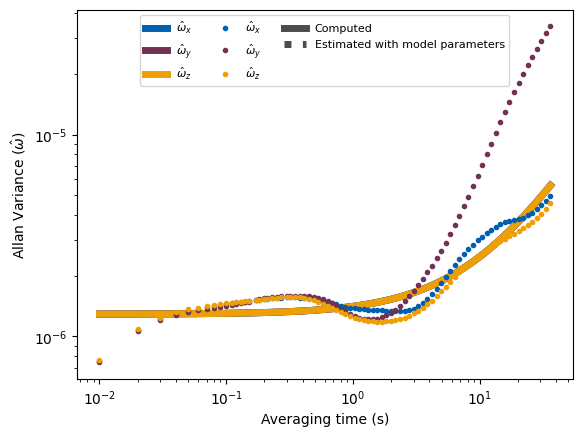

In [31]:
# DISIMU, omega hat
tau_wx, avar_wx = allan_variance.compute_avar(state_est_hist[:,0], dt)
tau_wy, avar_wy = allan_variance.compute_avar(state_est_hist[:,1], dt)
tau_wz, avar_wz = allan_variance.compute_avar(state_est_hist[:,2], dt)
params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
print(f"DISIMU omega hat: {params_wx}, {params_wy}, {params_wz}")

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_wx, avar_pred_wx, label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_pred_wx, label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_pred_wx, label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_wx, avar_wx, '.', label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_wy, '.', label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_wz, '.', label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 1])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

IMU 1 SF hat: quantization    0.00000205152298
white           0.00009691926858
flicker         0.00000000000000
walk            0.00105124790248
ramp            0.00006487878152
Name: 0, dtype: float64, quantization    0.00000360718892
white           0.00008217670482
flicker         0.00029458064279
walk            0.00090238690076
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000211212552
white           0.00009639179045
flicker         0.00000000000000
walk            0.00104703726551
ramp            0.00008115416503
Name: 0, dtype: float64
IMU 2 SF hat: quantization    0.00000350568386
white           0.00008293303962
flicker         0.00031938557296
walk            0.00080098125182
ramp            0.00010653300037
Name: 0, dtype: float64, quantization    0.00000390769896
white           0.00007946876153
flicker         0.00031402693437
walk            0.00083805888570
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000

Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

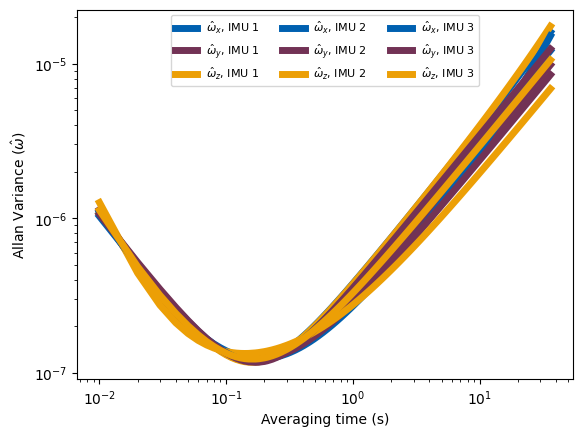

In [32]:
# individual IMUs, omega hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_wx, avar_wx = allan_variance.compute_avar(meas_hist[:,j*6], dt)
    tau_wy, avar_wy = allan_variance.compute_avar(meas_hist[:,j*6+1], dt)
    tau_wz, avar_wz = allan_variance.compute_avar(meas_hist[:,j*6+2], dt)
    params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
    params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
    params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
    print(f"IMU {j+1} SF hat: {params_wx}, {params_wy}, {params_wz}")

    # Estimated
    plt.loglog(tau_wx, avar_pred_wx, '-', label="$\hat{\omega}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_wy, avar_pred_wy, '-', label="$\hat{\omega}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_wz, avar_pred_wz, '-', label="$\hat{\omega}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

DISIMU omega hat: quantization    0.00000000000000
white           0.00001454424365
flicker         0.00019096848192
walk            0.00081950702972
ramp            0.00009443932457
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00001101024248
flicker         0.00014913588254
walk            0.00082570418490
ramp            0.00013264309243
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00000000000000
flicker         0.00749372523417
walk            0.00000000000000
ramp            0.00000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

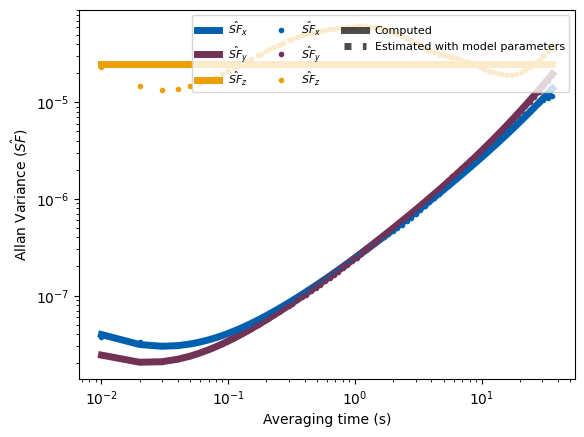

In [33]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(state_est_hist[:,6], dt)
tau_fy, avar_fy = allan_variance.compute_avar(state_est_hist[:,7], dt)
tau_fz, avar_fz = allan_variance.compute_avar(state_est_hist[:,8], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
print(f"DISIMU omega hat: {params_fx}, {params_fy}, {params_fz}")

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

IMU 1 SF hat: quantization    0.00001446700916
white           0.00013085771687
flicker         0.00099051808533
walk            0.00088357153136
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000981298191
white           0.00015555679773
flicker         0.00072056116371
walk            0.00118751839158
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000939245315
white           0.00020750977607
flicker         0.00062243945598
walk            0.00139893073881
ramp            0.00000000000000
Name: 0, dtype: float64/n
IMU 2 SF hat: quantization    0.00000809819871
white           0.00015367634241
flicker         0.00063951245247
walk            0.00120820326903
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00001434273678
white           0.00006562754082
flicker         0.00100068637118
walk            0.00088249116407
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.000

Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

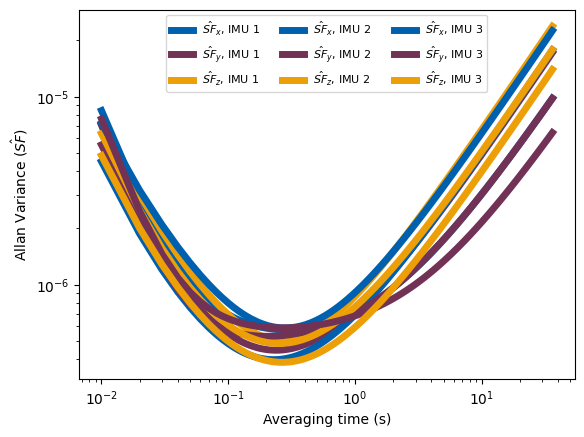

In [34]:
# individual IMUs, SF hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_fx, avar_fx = allan_variance.compute_avar(meas_hist[:,j*6+3], dt)
    tau_fy, avar_fy = allan_variance.compute_avar(meas_hist[:,j*6+4], dt)
    tau_fz, avar_fz = allan_variance.compute_avar(meas_hist[:,j*6+5], dt)
    params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
    params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
    params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
    print(f"IMU {j+1} SF hat: {params_fx}, {params_fy}, {params_fz}/n")

    # Estimated
    plt.loglog(tau_fx, avar_pred_fx, '-', label="$\hat{SF}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_fy, avar_pred_fy, '-', label="$\hat{SF}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_fz, avar_pred_fz, '-', label="$\hat{SF}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

Text(0, 0.5, '$\\hat{\\omega}$ (rad/s)')

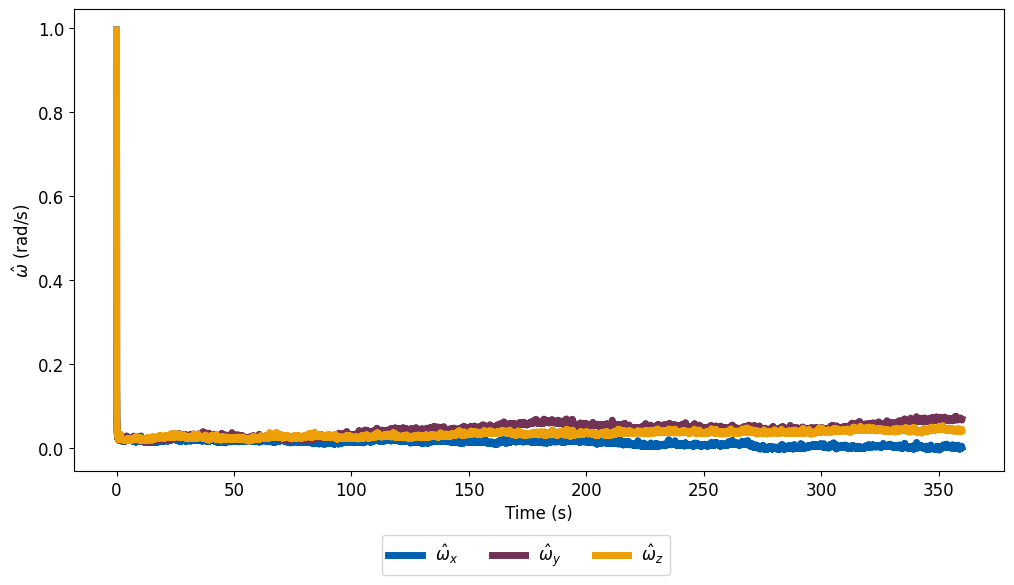

In [35]:
# single IMU, omega hat
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax1.plot(time[:], state_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax1.plot(time[:], state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.5, 2])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\omega}$ (rad/s)", fontsize=12)

Text(0, 0.5, '$\\omega$ (rad/s)')

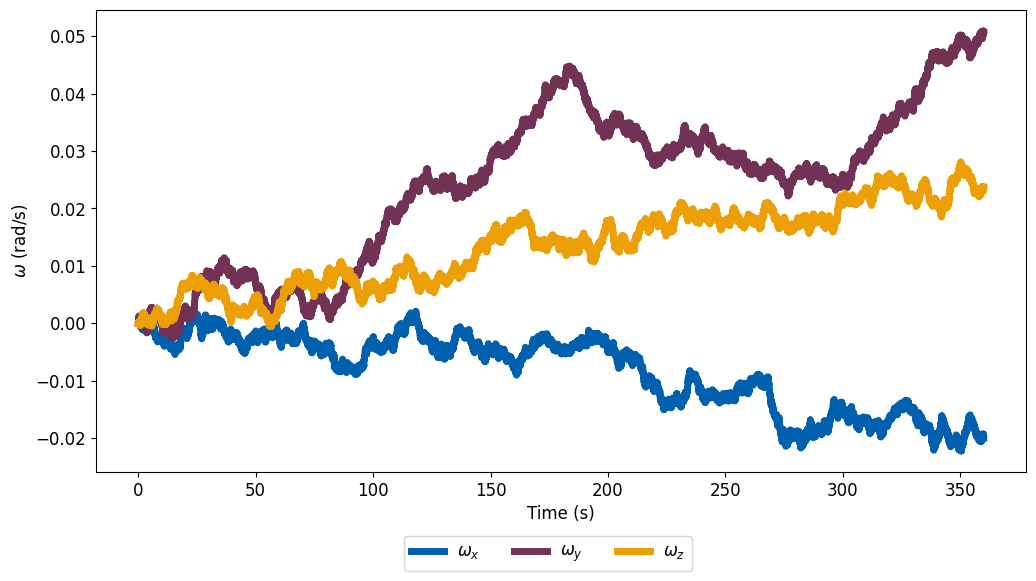

In [36]:
# omega
fig2, ax2 = plt.subplots(figsize = (12, 6))
ax2.plot(time[:], state_hist[:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax2.plot(time[:], state_hist[:,1], linewidth=5, color = "#723255", label = "$\omega_y$")
ax2.plot(time[:], state_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\omega_z$")
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax2.set_xlabel("Time (s)", fontsize=12)
# ax2.set_ylim([-0.005, 0.005]) # using same units as above
ax2.set_ylabel("$\omega$ (rad/s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

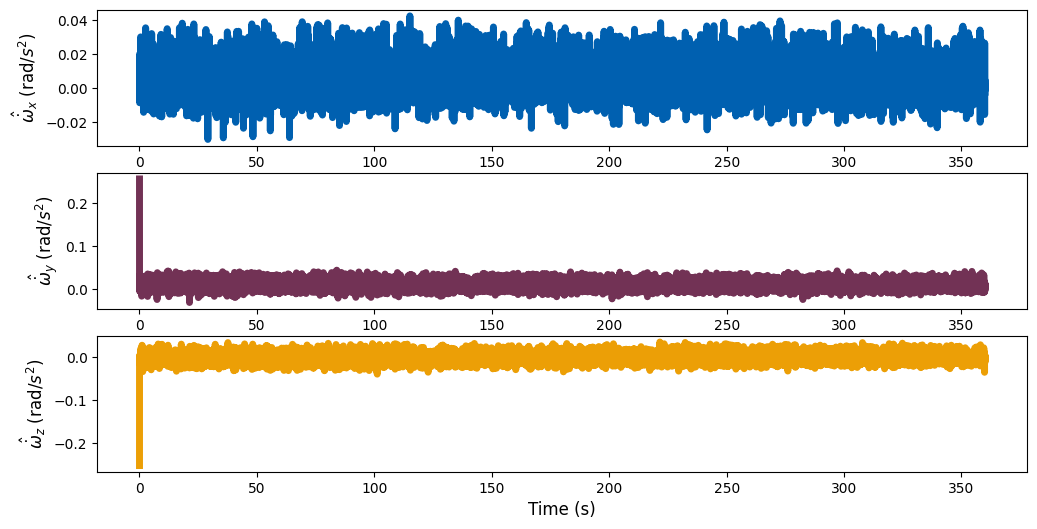

In [37]:
# fused omega hat dot
fig3, ax3 = plt.subplots(3, 1, figsize = (12, 6))
ax3[0].plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax3[1].plot(time, state_est_hist[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax3[2].plot(time, state_est_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
# ax3[0].set_ylim([-0.1, 0.1])
# ax3[1].set_ylim([-0.1, 0.1])
# ax3[2].set_ylim([-0.1, 0.1])
ax3[0].set_ylabel("$\hat{\dot{\omega}}_x$ (rad/$s^2$)", fontsize=12)
ax3[1].set_ylabel("$\hat{\dot{\omega}}_y$ (rad/$s^2$)", fontsize=12)
ax3[2].set_ylabel("$\hat{\dot{\omega}}_z$ (rad/$s^2$)", fontsize=12)
ax3[2].set_xlabel("Time (s)", fontsize=12)

Text(0, 0.5, '$\\dot{\\omega}$ (rad/s)')

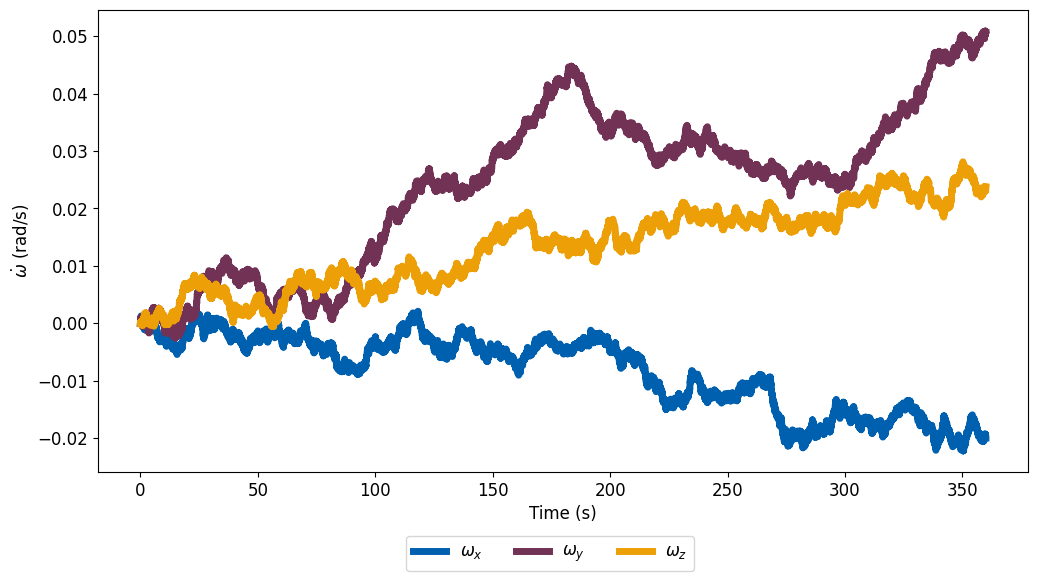

In [38]:
# dynamics, omega dot
fig4, ax4 = plt.subplots(figsize = (12, 6))
ax4.plot(time[:], state_hist[:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax4.plot(time[:], state_hist[:,1], linewidth=5, color = "#723255", label = "$\omega_y$")
ax4.plot(time[:], state_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\omega_z$")
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax4.set_xlabel("Time (s)", fontsize=12)
# ax4.set_ylim([-0.005, 0.005]) # using same units as above
ax4.set_ylabel("$\dot{\omega}$ (rad/s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

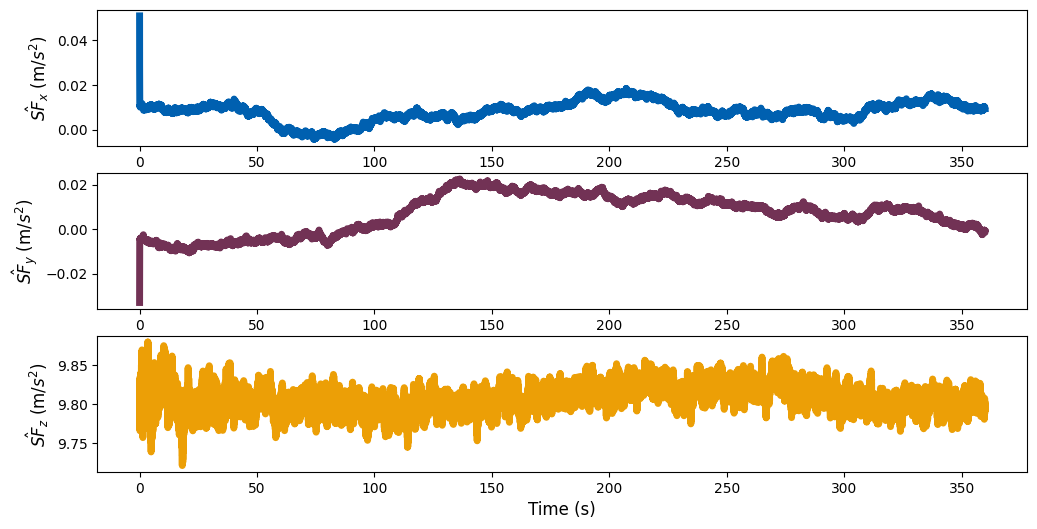

In [39]:
# system, SF hat
fig5, ax5 = plt.subplots(3, 1, figsize = (12, 6))
ax5[0].plot(time, state_est_hist[:,6], linewidth=5, color = "#0060B0", label = "$\hat{SF}_x$")
ax5[1].plot(time, state_est_hist[:,7], linewidth=5, color = "#723255", label = "$\hat{SF}_y$")
ax5[2].plot(time, state_est_hist[:,8], linewidth=5, color = "#EC9F06", label = "$\hat{SF}_z$")
# ax5[0].set_ylim([-0.1, 0.1])
# ax5[1].set_ylim([-0.1, 0.1])
# ax5[2].set_ylim([-0.1, 0.1])
ax5[0].set_ylabel("$\hat{SF}_x$ (m/$s^2$)", fontsize=12)
ax5[1].set_ylabel("$\hat{SF}_y$ (m/$s^2$)", fontsize=12)
ax5[2].set_ylabel("$\hat{SF}_z$ (m/$s^2$)", fontsize=12)
ax5[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

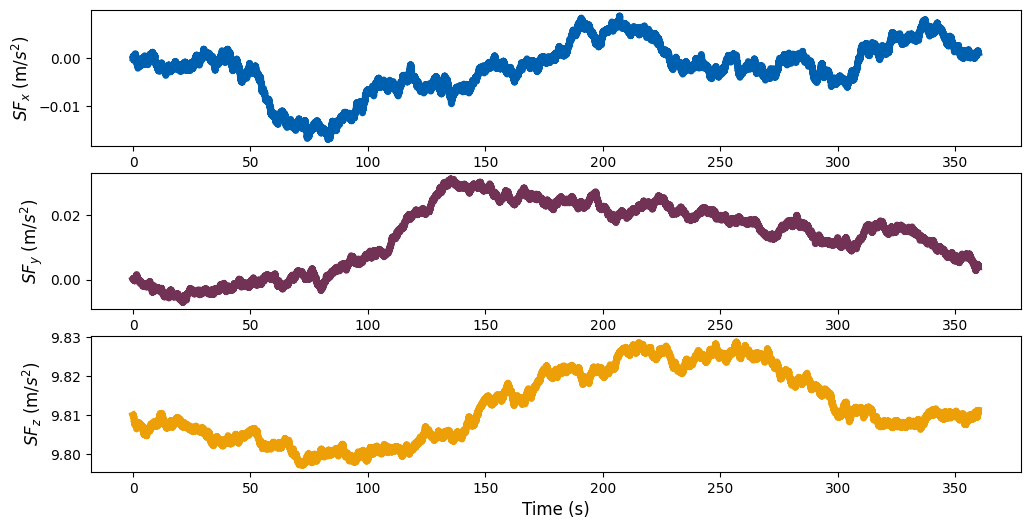

In [40]:
# dynamics, SF
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,6])
# plt.plot(time, state_hist[:,7])
# plt.plot(time, state_hist[:,8])
# plt.title("specific force")

fig6, ax6 = plt.subplots(3, 1, figsize = (12, 6))
ax6[0].plot(time, state_hist[:,6], linewidth=5, color = "#0060B0", label = "$SF_x$")
ax6[1].plot(time, state_hist[:,7], linewidth=5, color = "#723255", label = "$SF_y$")
ax6[2].plot(time, state_hist[:,8], linewidth=5, color = "#EC9F06", label = "$SF_z$")
# ax3[0].set_ylim([-0.0025, 0.0025])
# ax3[1].set_ylim([-0.0025, 0.0025])
# ax3[2].set_ylim([-0.0025, 0.0025])
# ax6[0].set_ylim([-0.005, 0.005])
# ax6[1].set_ylim([-0.005, 0.005])
# ax6[2].set_ylim([-0.005, 0.005])
ax6[0].set_ylabel("$SF_x$ (m/$s^2$)", fontsize=12)
ax6[1].set_ylabel("$SF_y$ (m/$s^2$)", fontsize=12)
ax6[2].set_ylabel("$SF_z$ (m/$s^2$)", fontsize=12)
ax6[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

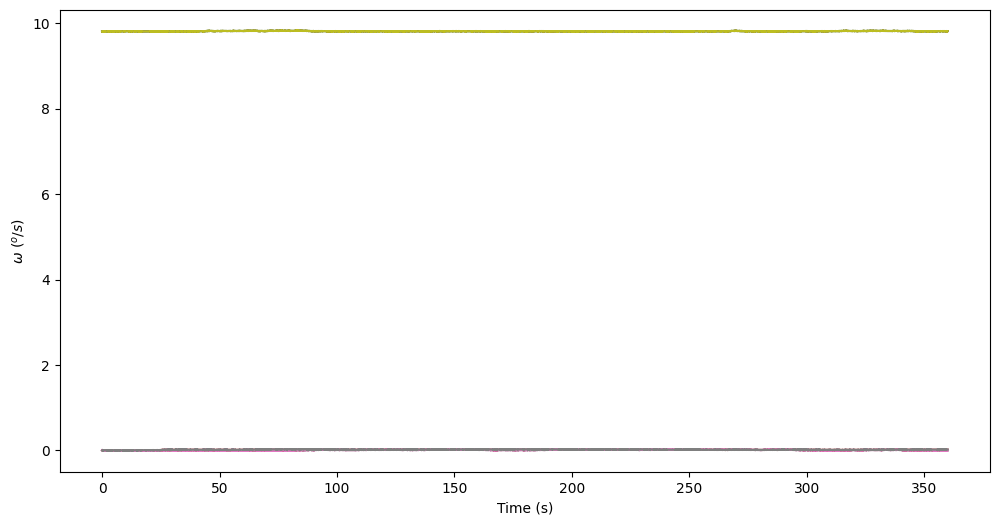

In [41]:
plt.figure(figsize = (12, 6))
for jth in range(num_imus):
    plt.plot(time, meas_hist[:,j*6])
    plt.plot(time, meas_hist[:,j*6+1])
    plt.plot(time, meas_hist[:,j*6+2])
plt.ylabel("$\omega$ ($^o/s$)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

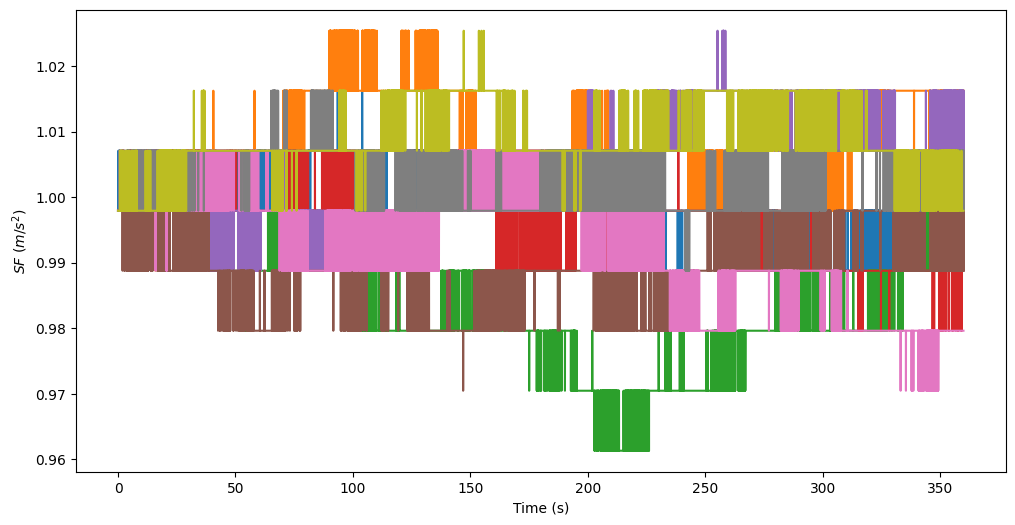

In [42]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6+3])
    plt.plot(time, meas_hist[:,j*6+4])
    plt.plot(time, meas_hist[:,j*6+5])
plt.ylabel("$SF$ ($m/s^2$)")
plt.xlabel("Time (s)")

In [43]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,9])
plt.plot(time, state_est_hist[:,10])
plt.plot(time, state_est_hist[:,11])
plt.title("RW")

IndexError: index 9 is out of bounds for axis 1 with size 9

<Figure size 1200x600 with 0 Axes>

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,12])
plt.plot(time, state_est_hist[:,13])
plt.plot(time, state_est_hist[:,14])
plt.title("RW")

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,15])
plt.plot(time, state_est_hist[:,16])
plt.plot(time, state_est_hist[:,17])
plt.title("RW")

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,18])
plt.plot(time, state_est_hist[:,19])
plt.plot(time, state_est_hist[:,20])
plt.title("GM")